<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [58]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7,activation='LeakyReLU',use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(14*14,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='sigmoid',use_bias=False))
    model.add(layers.Reshape((28,28,1)))

    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(input_img)

    x = layers.Dropout(.2)(x)

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.2)(x)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)


    x = layers.Dropout(.2)(x)

    dense_output = layers.Dense(64, activation='LeakyReLU')(x)

    x = layers.Dropout(.2)(x)

    dense_output = layers.Dense(1, activation=None)(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model



In [59]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [134]:
generator = make_generator_model()
discriminatorW = make_discriminator_model()
discriminatorU = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorW_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.00004)

In [101]:
BATCH_SIZE = 10

#@tf.function
def discriminator_lossW(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_lossW(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminatorW(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [138]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])



    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW, tf.GradientTape() as disc_tapeU:
        generated_images = generator(noise, training=True)

        real_outputW = discriminatorW(images, training=True)
        fake_outputW = discriminatorW(generated_images, training=True)

        real_outputU = discriminatorU(images, training=True)
        fake_outputU = discriminatorU(generated_images, training=True)

        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)
        disc_lossU = cross_entropy(tf.ones_like(real_outputU), real_outputU)


        gen_loss = cross_entropy(tf.ones_like(fake_outputU), fake_outputU)*25
        gen_loss += generator_lossW(fake_outputW)

        gp = gradient_penalty(images, generated_images)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    gradients_of_discriminatorU = disc_tapeU.gradient(disc_lossU, discriminatorU.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))
    discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminatorU, discriminatorU.trainable_variables))

    tf.print("disc_lossW",disc_lossW,'disc_lossU',disc_lossU,'gen_loss',gen_loss)

In [139]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [140]:
EPOCHS = 10
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_lossW -12.5298901 disc_lossU 0.0225407258 gen_loss 17.4304619
disc_lossW -12.6457148 disc_lossU 0.0237496402 gen_loss 17.3700867
disc_lossW -11.947258 disc_lossU 0.0180955119 gen_loss 17.3964729
disc_lossW -12.5145702 disc_lossU 0.0138050644 gen_loss 17.3065948
disc_lossW -12.3337383 disc_lossU 0.0260891765 gen_loss 16.7424278
disc_lossW -11.9052296 disc_lossU 0.0135772526 gen_loss 16.8522644
disc_lossW -11.7369528 disc_lossU 0.0157211032 gen_loss 16.8954182
disc_lossW -12.2761278 disc_lossU 0.0181069914 gen_loss 16.4557095
disc_lossW -11.3550653 disc_lossU 0.00990600232 gen_loss 16.502985
disc_lossW -12.4294233 disc_lossU 0.0149081247 gen_loss 16.4538269
disc_lossW -11.8115282 disc_lossU 0.0202697478 gen_loss 15.890626
disc_lossW -11.1055565 disc_lossU 0.0117165083 gen_loss 15.5780392
disc_lossW -11.4090319 disc_lossU 0.0142109366 gen_loss 15.7628965
disc_lossW -11.7481298 disc_lossU 0.0119959386 gen_loss 15.4509239
disc_lossW -11.7920609 disc_lossU 0.0153074414 gen_loss 15.58031

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 17ms/step


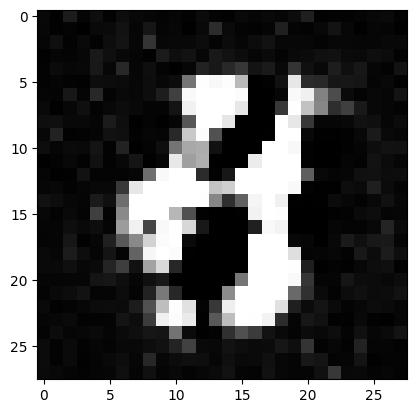

In [150]:
noise = tf.random.normal(shape=(1,100))
test = generator.predict(noise)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(np.min(x_train2))